In [1]:
import numpy as np
import gzip
import json
from vowpalwabbit import pyvw
from ips_snips import Estimator
import matplotlib.pyplot as plt

In [2]:
def get_data(filename):
    with gzip.GzipFile(filename, 'r') as fin:   
        data=[]
        for line in fin:
            data.append(line.decode('utf-8'))
    return data

In [3]:
def off_pol_train_eval(vw,data,estimate,interval,N):    
    est=Estimator()
    ctr=[]
    ctr_hi=[]
    ctr_lo=[]
    ctr_log=[]
    ctr_sum=0.
    for i in range(len(data)-1):        
        pmf=vw.predict(data[i])        
        temp=json.loads(data[i])
        prob_log=temp['_label_probability']
        cost_log=temp['_label_cost']
        action_log=temp['_labelIndex']
        pmf=np.array(pmf)
        pmf=pmf/sum(pmf)       
        prob_pred=pmf[int(action_log)]
        est.add_example(prob_log,-1*cost_log,prob_pred)
        ctr_sum+=cost_log
        vw.learn(data[i])
        vw.finish_example(data[i])
#         if((i>0) and (i%N==0)):
        if(i%N==0):
            ctr.append(est.get_estimate(estimate))
            confidence=est.get_interval(interval)
            ctr_lo.append(confidence[0])
            ctr_hi.append(confidence[1])
            ctr_log.append(-1*ctr_sum/N)
            ctr_sum=0.
            est=Estimator()
    return ctr,ctr_lo,ctr_hi,ctr_log          

In [36]:
def plot_ctr(ctr,ctr_lo,ctr_hi,ctr_log,ctr_off,ctr_lo_off,ctr_hi_off,N):
    num_iter=len(ctr)
    x=[N*i for i in range(0,num_iter)]
    plt.plot(x,ctr,'--b',label='Learnt')    
    plt.fill_between(x, ctr_lo,ctr_hi, alpha=0.4)
    plt.plot(x,ctr_log,'--r',label='Logging')
    plt.plot(x,ctr_off,'--g',label='Batch Learnt') 
    plt.fill_between(x, ctr_lo_off,ctr_hi_off,'g',alpha=0.4)    
    plt.xlabel('Events', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.legend()
    plt.grid()    
    plt.savefig('OffJson.pdf')
    plt.savefig('OffJson.png')
    plt.savefig('OffJson.jpg')
       

In [5]:
def off_train(vw,data):
    for i in range(len(data)-1):
        vw.learn(data[i])
        vw.finish_example(data[i])
    return vw   

In [9]:
def off_eval(agent,data,N):
    est=Estimator()
    ctr=[]
    ctr_hi=[]
    ctr_lo=[]    
    for i in range(len(data)-1):        
        pmf=agent.predict(data[i])        
        temp=json.loads(data[i])
        prob_log=temp['_label_probability']
        cost_log=temp['_label_cost']
        action_log=temp['_labelIndex']
        pmf=np.array(pmf)
        pmf=pmf/sum(pmf)       
        prob_pred=pmf[int(action_log)]
        est.add_example(prob_log,-1*cost_log,prob_pred)             
        if(i%N==0):
            ctr.append(est.get_estimate(estimate))
            confidence=est.get_interval(interval)
            ctr_lo.append(confidence[0])
            ctr_hi.append(confidence[1])            
            est=Estimator()
    return ctr,ctr_lo,ctr_hi  

In [7]:
filename='testdata.json.gz'
interval='gaussian'
estimate='ips'
N=10000
data=get_data(filename)
########################################################################
vw = pyvw.vw("--cb_explore_adf -q Ua --dsjson --quiet --epsilon 0.")
ctr,ctr_lo,ctr_hi,ctr_log=off_pol_train_eval(vw,data,estimate,interval,N)


In [10]:
########################################################################
vw = pyvw.vw("--cb_explore_adf -q Ua --dsjson --quiet --epsilon 0.")
agent=off_train(vw,data)
ctr_off,ctr_lo_off,ctr_hi_off=off_eval(agent,data,N)

C:\Users\t-desikr\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  


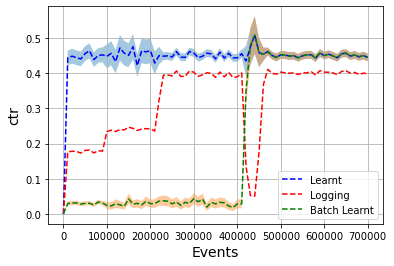

In [37]:
plot_ctr(ctr,ctr_lo,ctr_hi,ctr_log,ctr_off,ctr_lo_off,ctr_hi_off,N)